In [1]:
import numpy as np
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import train_utils
from models import CharRNN
import pickle
import Levenshtein # for calculating distance between strings.
from time import time
%load_ext autoreload
%autoreload 2

print(torch.cuda.is_available())

True


# Set up code

In [2]:
# should this be val? 
# read in the extracted text file
with open('datasets/text8_val') as f:
    text_val = f.read()

# print out the first 100 characters
chars = tuple(set(text_val))

int2char = dict(enumerate(chars))

char2int = {ch: ii for ii, ch in int2char.items()}

print('first 100 chars are: ', text_val[:100])
encoded = np.array([char2int[ch] for ch in text_val[:10000]])
print('length of dataset is: ', len(encoded))
batches = train_utils.get_batches(encoded, 10, 50)
x, y = next(batches)

print('x shape is ', x.shape, '\n', x[:2, :10])
print('\ny is just x shifted by 1\n', y[:2, :10])


first 100 chars are:  the fires took over nine months to fully extinguish and the cost of repairs to oil infrastructure ex
length of dataset is:  10000
x shape is  (10, 50) 
 [[26 13 16  4 22 14  3 17 11 10]
 [14 26  4 11  1 24 20  3  7 13]]

y is just x shifted by 1
 [[13 16  4 22 14  3 17 11 10  4]
 [26  4 11  1 24 20  3  7 13 10]]


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

def keyboard_heatmap(p, char_tuple):
    ''' takes a softmax over characters, and plots heatmap over the keyboard
      This will be useful for
      - debugging
      - writing the final report  '''
    keyboard = {0:'qwertyuiop',1:'asdfghjkl',2:'zxcvbnm',3:' '}

    int2char = dict(enumerate(char_tuple))
    char2int = {ch: ii for ii, ch in int2char.items()}

    keyboard_heatmap = np.zeros((4,10))
    # iterate through the softmax vector and fill in the heatmap values
    # can definitely be rewritten to run faster, this first solution that came to mind is stupid slow, but speeds not important
    for i in range(np.shape(p)[0]):
        char_temp = char_tuple[i]
        temp_key_column = -1
        # find corresponding location of key on keyboard
        for row in range(4):
            temp_key_column = keyboard[row].rfind(char_temp)
            if temp_key_column != -1:
                temp_key_row = row
                break
        # fill location of key in heatmap with the softmax value
        keyboard_heatmap[temp_key_row,temp_key_column] = p[i]
        # plot
    sns.heatmap(keyboard_heatmap, square = True, linewidths=1, linecolor='lightsteelblue', cmap=mpl.colormaps['Reds'])
    for row in keyboard:
        for j,letter in enumerate(keyboard[row]):
            plt.text(0.5+j,0.5+row,'\''+letter+'\'',
                  horizontalalignment='center',
                  verticalalignment='center', color = 'green')

# language generation example

In [4]:
# if you need a text corpus to evaluate the language generation eprformance on, use this.
with open('datasets/text8_test') as f:
    text_test = f.read()

In [5]:
# LSTM argmax language generation example
file_name = 'saved_models/charRNN_scratch.pkl'
lm_lstm = torch.load(file_name)


thing = 'a'
next_char, h, _= lm_lstm.predict('a')
thing = thing + next_char
for i in range(200):
    next_char, h, _= lm_lstm.predict(thing[-1], h)
    thing = thing + next_char
print(thing)

a cattle pennsylvakin mare club is camerilles the colpe mosn amatous it was accused of triban differently control god s preservation of authorshal event has been still death pollinates do itonameloacour


# Demonstrations of how functions work

true character is ' h ', but the simulated EMG decoder softmax is
[0.21 0.01 0.   0.17 0.   0.   0.   0.18 0.   0.   0.   0.   0.05 0.
 0.   0.   0.2  0.   0.   0.   0.08 0.   0.   0.09 0.   0.   0.  ]


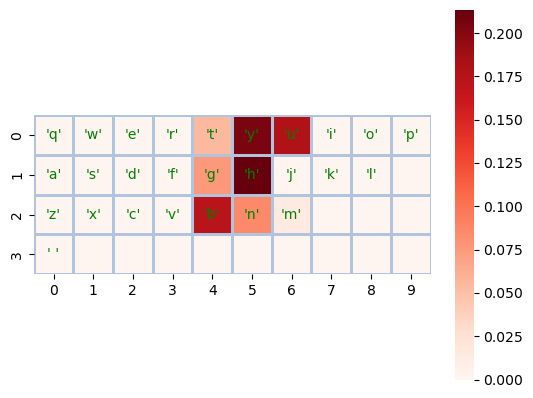

true character is ' h ', but the simulated EMG decoder softmax is
[0.29 0.   0.   0.31 0.   0.   0.   0.   0.14 0.   0.   0.   0.   0.
 0.   0.   0.   0.03 0.   0.   0.18 0.   0.   0.06 0.   0.   0.  ]


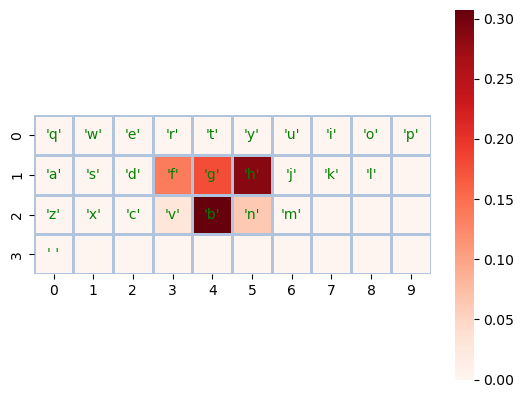

In [6]:
# load a model that I trained in another notebook on the text8 dataset
file_name = 'saved_models/charRNN_scratch.pkl'
lm_lstm = torch.load(file_name)

char = 'h'
# convert the character to the simulated output of the EMG decoder. I just move
#   some probability to the adjacent keys on the keyboard. You can see this in the
#   heatmap below.
for i in range(2):
    # choose between skilled and unskilled typing style
    p = train_utils.letter_to_emg_sim(char, lm_lstm.chars,typing_style = 'skilled')
    print('true character is \'',char,'\', but the simulated EMG decoder softmax is')
    print(np.round(p,2))
    keyboard_heatmap(p, lm_lstm.chars)
    plt.show()

Below, I show the ground truth sentence. Followed by the output if letters are randomly sampled from the simulated EMG softmax. Followed by argmax decoding on the multiplied softmax of the character level language model RNN and the simulated EMG softmax (p_lm*p_emg). You can see that the charRNN brings the accuracy from 50% up to around 85%.

# concrete examples and accuracies on an example sentence

In [7]:
# import your model
# run function toe valuate with simulate EMG
def EMG_LM_decoder(char_tuple, p_emg, p_lm = None):
    if p_lm is None:
        return char_tuple[np.argmax(p_emg)]
    p_combined = p_lm*p_emg
    p_combined = p_combined/p_combined.sum()
    letter_index = np.argmax(p_combined)
    return char_tuple[letter_index]

gt_sentence = 'when she shouted the gulls hidden by the dune buckshot the low clouds'

# argmax from simulated EMG decoder output
emg_sentence = ''

p_emg = train_utils.letter_to_emg_sim(gt_sentence[0], lm_lstm.chars)
first_char = EMG_LM_decoder(lm_lstm.chars, p_emg)

emg_sentence = emg_sentence + first_char
for i in range(1, len(gt_sentence)):
    # create simulated emg decoder output from ground truth, multiply with lm to decode
    p_emg = train_utils.letter_to_emg_sim(gt_sentence[i], lm_lstm.chars)
    next_char = EMG_LM_decoder(lm_lstm.chars, p_emg)
    emg_sentence = emg_sentence + next_char

# decode with lm
decoded_sentence = ''

p_emg = train_utils.letter_to_emg_sim(gt_sentence[0], lm_lstm.chars)
first_char = EMG_LM_decoder(lm_lstm.chars, p_emg)

decoded_sentence = decoded_sentence + first_char
_, h, p_lm = lm_lstm.predict(first_char)
for i in range(1, len(gt_sentence)):
    # create simulated emg decoder output from ground truth, multiply with lm to decode
    p_emg = train_utils.letter_to_emg_sim(gt_sentence[i], lm_lstm.chars)
    next_char = EMG_LM_decoder(lm_lstm.chars, p_emg, p_lm)
    decoded_sentence = decoded_sentence + next_char

    _, h, p_lm = lm_lstm.predict(next_char, h)

print('> ground truth sentence')
print(gt_sentence,'\n')

print('> argmax of simulated EMG decoding')
print(emg_sentence)
print(Levenshtein.ratio(gt_sentence, emg_sentence),'\n')

print('> generated by argmax from EMG probability multiplied by RNN-LM')
print(decoded_sentence, '\n')

print(Levenshtein.ratio(gt_sentence, emg_sentence), ' simulated EMG accuracy')
print(Levenshtein.ratio(gt_sentence, decoded_sentence),' EMG + LM accuracy')

print('\n> notably there is not much improvement without beam search/probability smoothing')

> ground truth sentence
when she shouted the gulls hidden by the dune buckshot the low clouds 

> argmax of simulated EMG decoding
aben suf ctohtfd hbemnullq midden hy tbs dugs fucmctoh the iowbcpohxs
0.5942028985507246 

> generated by argmax from EMG probability multiplied by RNN-LM
whermans chomber hus thole hissen by husbakke themshot the piecciomes 

0.5942028985507246  simulated EMG accuracy
0.5652173913043479  EMG + LM accuracy

> notably there is not much improvement without beam search/probability smoothing


# Comparing BEAM search widths

In [8]:
with open('datasets/text8_test') as f:
    text_test = f.read()

## different decoding strategies with lstm lm

In [9]:
from numpy import array

def EMG_LM_decoder(char_tuple, p_emg, p_lm = None, delta_emg = 0, delta_lm = 0):
    p_emg = p_emg + delta_emg
    p_lm = p_lm + delta_lm
    p_combined = p_lm*p_emg
    p_combined = p_combined/p_combined.sum()
    letter_index = np.argmax(p_combined)
    return char_tuple[letter_index], p_combined

file_name = 'saved_models/charRNN_scratch.pkl'
lm_lstm = torch.load(file_name)

results = {}
from time import time

delta_emg = 0.01
delta_lm = .08

# argmax from simulated EMG decoder output
test_batch_size = 500
num_batches = 2
batch = 0
times = []

ratios = []
avg_ratios = [0]

accuracies = []
avg_accuracies = [0]
for beta in [2,8,32]:
    print('beta: ', beta)
    for batch in range(num_batches):

        start = time()

        gt_sentence = text_test[(batch+1)*test_batch_size:(batch+2)*test_batch_size]

        # vvvvvvvvvvvvv MODIFY BELOW vvvvvvvvvvvv
        decoded_sentences = [['',None,1]]

        p_emg = train_utils.letter_to_emg_sim(gt_sentence[0], lm_lstm.chars)
        # loop through paths so far, and extend each path with the most probable delta seqs
        paths_at_tier = []
        for sentence_candidate in decoded_sentences:
            path, h, prob = sentence_candidate
            # find top delta likely characters
            top_beta_indices = np.argpartition(p_emg, -27)[-27:]
            for top_beta_index in top_beta_indices:
                _, h, p_lm = lm_lstm.predict(lm_lstm.chars[top_beta_index])
                paths_at_tier.append([path+lm_lstm.chars[top_beta_index], None, prob*p_emg[top_beta_index]])

        paths_ordered = sorted(paths_at_tier, key=lambda element: element[2])
        decoded_sentences = paths_ordered[-beta:]

        renorm = False
        for i in range(1, len(gt_sentence)):

            paths_at_tier = []
            for sentence_candidate in decoded_sentences:
                path, h, prob = sentence_candidate
                if prob < 1e-2:
                    renorm = True
                # find top delta likely characters
                p_emg = train_utils.letter_to_emg_sim(gt_sentence[i], lm_lstm.chars)
                
                _, h, p_lm = lm_lstm.predict(path[-1], h)
                p_lm = p_lm[0]

                _, p_beam = EMG_LM_decoder(lm_lstm.chars, p_emg, p_lm, delta_lm = delta_lm, delta_emg = delta_emg)

                top_beta_indices = np.argpartition(p_beam, -27)[-27:]
                for top_beta_index in top_beta_indices:
                    paths_at_tier.append([path+lm_lstm.chars[top_beta_index], h, prob*p_beam[top_beta_index]])
            paths_ordered = sorted(paths_at_tier, key=lambda element: element[2])
            decoded_sentences = paths_ordered[-beta:]
            
            # renormalizing the beam probabilities to prevent underflow
            if renorm:
                for j, sentence_candidate in enumerate(decoded_sentences):
                    _, _, p = sentence_candidate
                    decoded_sentences[j][2] = p/1e-4
                renorm = False
        decoded_sentence = decoded_sentences[0][0]
        print(decoded_sentence)
        
        # ^^^^^^^^^^ MODIFY ABOVE ^^^^^^^^^^^^^^^
        accuracy = np.sum(np.array(list(gt_sentence)) == np.array(list(decoded_sentence)))/len(gt_sentence)
        accuracies.append(accuracy)
        avg_accuracies.append( (avg_accuracies[-1]*batch + accuracy)/(batch+1))

        ratio = Levenshtein.ratio(gt_sentence, decoded_sentence)
        ratios.append(ratio)
        avg_ratios.append( (avg_ratios[-1]*batch + ratio)/(batch+1))

        end = time()
        times.append(end-start)
        print('test levenshtein score: ', avg_ratios[-1])

    results[beta] = avg_ratios[-1]
    print('test levenshtein score: ', avg_ratios[-1])
    import pickle
    from datetime import datetime
    save_path = ''
    time_result = "{:%Y_%m_%d_%H_%M_}".format(datetime.now())
    # with open(save_path+'results_beam_ '+time_result+'.pkl', 'wb') as f:
    #     pickle.dump(results, f)
print(results)


beta:  2
relejasncf other treanmrungilvmts filph ar the fike aege fre isiaclo centeopas arees xig hbs edpanejin or lazeo cenlanderigna s ka challenkje es the olde freiliriknary togethkerf it mediconeoulodign the medican revolution of jnf joje one zero reinfogced the hmiortanse on the sott shift casnat jopketame influx of inmigrangs dogong the gest of the halbssri bu centuri bown of the truegu of kealek tory in population occurred on the isge mak serk tt cautigu jm one nine five sevoveut city har anoun tm
test levenshtein score:  0.6659999999999999
def hillion onharitanta hungaovastu sericatek the fctioated polilation for the memropkpiten wresnwas armonc one sight toiillg recent fostory it ijs hone corneidht the firy wea tost or the kiyopje gamee but it was also staljed anth the massacre of seussner by secendingtoils whgitr the towtelloco massache whotver soonf edenh carroce on part cybthf vody das ctanbura aprpd col of one nine seven zero thet the founhey histsd and dnoct has lta brand